In [2]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torchvision import datasets, transforms

import numpy as np
import pandas as pd
import time
torch.__version__
import random
import matplotlib.pyplot as plt

In [33]:
BATCH_SIZE = 100

traindb=datasets.MNIST('data', train=True, download=True, #cifar10数据集是经典数据集，可以直接载入，第一次使用需要下载。
                       transform=transforms.Compose([
                           transforms.ToTensor(), # 转换成torch.tensor
                       ]))

train_db, val_db, drop_db= torch.utils.data.random_split(traindb, [8000, 2000,50000]) #这里将数据集分成了三份，为了看网络在小样本数据下的性能，
#（接上一行）这里将40000个数据直接扔掉了，5000个训练数据，5000个验证数据，这三个加起来，要等于总的数据50000个。
# train_db, val_db= torch.utils.data.random_split(traindb, [40000, 10000])

print('db1:', len(train_db), 'db2:', len(val_db))
train_loader = torch.utils.data.DataLoader(   #搞出一个训练集
    train_db,
    batch_size=BATCH_SIZE, shuffle=True)
val_loader = torch.utils.data.DataLoader(     #搞出一个验证集
    val_db,
    batch_size=BATCH_SIZE, shuffle=True)

print(len(train_loader))

db1: 8000 db2: 2000
80


In [34]:
class customF(nn.Module): #咱们的激活函数，阈值+噪声


    def __init__(self, width):
        super().__init__()
        self.sigma = nn.Parameter(torch.rand(1, width, 1, 1)) #两个可学习参数 sigma 和 theta
        self.theta = nn.Parameter(torch.rand(1, width, 1, 1))

    def forward(self, input):
      #  temp1=self.sigma*torch.exp(-input*input/2/self.sigma/self.sigma)/2.506628
        temp=0.5-torch.erf((self.theta-input)/self.sigma/1.4142136)/2 #前向传播过程
      #  return temp1+temp2
        return temp

In [35]:
class customFC(nn.Module): #咱们的激活函数，阈值+噪声


    def __init__(self, width):
        super().__init__()
        self.sigma = nn.Parameter(torch.randn(1, width)) #两个可学习参数 sigma 和 theta
        self.theta = nn.Parameter(torch.randn(1, width))

    def forward(self, input):
      #  temp1=self.sigma*torch.exp(-input*input/2/self.sigma/self.sigma)/2.506628
        temp=0.5-torch.erf((self.theta-input)/self.sigma/1.4142136)/2 #前向传播过程
      #  return temp1+temp2
        return temp

In [36]:
class ConvNet(nn.Module): 
    def __init__(self):
        super().__init__()

        self.convdense = nn.Sequential(
            nn.Conv2d(1, 20, 3, padding=1),
            nn.BatchNorm2d(20)
            
        )
        self.customdense = customF(20)

        self.fc1 = nn.Linear(3920, 256) 
        self.customFc1 = customFC(256)
        self.fc2 = nn.Linear(256, 10) 
    def forward(self,x):
        in_size = x.size(0) 
        out = self.convdense(x)
        
       
        out = self.customdense(out) 
        out = torch.max_pool2d(out, 2, 2)
        

               
        out = out.view(in_size, -1) 
        out = self.fc1(out) 
        out = self.customFc1(out)
         
        out = self.fc2(out) 
        out = F.log_softmax(out, dim=1) 
        return out

In [48]:
class ConvNet(nn.Module): #激活函数为 Sigmoid 函数  最后分类层为softmax。
    def __init__(self):
        super().__init__()

        self.conv1 = nn.Conv2d(1, 20, 3, padding=1) 
        self.bn1 = nn.BatchNorm2d(20)
        #self.custom1 = customF(16)  
    
        #self.conv2 = nn.Conv2d(6, 32, 3,padding=1) 
        #self.custom2 = customF(32)
     
        self.fc1 = nn.Linear(3920, 256) 
        self.fc2 = nn.Linear(256, 10) 
    def forward(self,x):
        in_size = x.size(0) 
        out = self.conv1(x) 
        out = self.bn1(out) 
       
        out = F.max_pool2d(out, 2, 2)
        out = F.sigmoid(out)
        
        
        #out = self.conv2(out) 
       # out = self.custom2(out,32) 
        #out = F.max_pool2d(out, 2, 2)
               
        out = out.view(in_size, -1) 
        out = self.fc1(out) 
        out = F.sigmoid(out)
        out = self.fc2(out) 
        out = F.log_softmax(out, dim=1) 
        return out

In [55]:
class ConvNet(nn.Module): ##激活函数为 Relu 函数  最后分类层为softmax。
    def __init__(self):
        super().__init__()

        self.conv1 = nn.Conv2d(1, 20, 3, padding=1) 
        self.bn1 = nn.BatchNorm2d(20)
        #self.custom1 = customF(16)
    
        #self.conv2 = nn.Conv2d(6, 32, 3,padding=1) 
        #self.custom2 = customF(32)
     
        self.fc1 = nn.Linear(3920, 256) 
        self.fc2 = nn.Linear(256, 10) 
    def forward(self,x):
        in_size = x.size(0) 
        out = self.conv1(x) 
        out = self.bn1(out) 
        
        out = F.max_pool2d(out, 2, 2)
        out = F.relu(out)
        
        
        #out = self.conv2(out) 
       # out = self.custom2(out,32) 
        #out = F.max_pool2d(out, 2, 2)
               
        out = out.view(in_size, -1) 
        out = self.fc1(out) 
        out = F.relu(out) 
        out = self.fc2(out) 
        out = F.log_softmax(out, dim=1) 
        return out

In [37]:
SEED = 6023

torch.manual_seed(SEED)
torch.cuda.manual_seed_all(SEED)
np.random.seed(SEED)
random.seed(SEED)
torch.backends.cudnn.deterministic = True



EPOCHS=100# 总共训练批次
DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu") 
#DEVICE = ("cpu")
model = ConvNet().to(DEVICE)
#model = ConvNet().cuda()
#optimizer = optim.Adam(model.parameters(), lr=0.01,betas=(0.90,0.999))
optimizer = optim.SGD(model.parameters(), lr = 0.1, momentum=0) #这里用的是SGD算法

In [38]:
def train(model, device, train_loader, optimizer, epoch):
    model.train()
    for batch_idx, (data, target) in enumerate(train_loader):
        data, target = data.to(device), target.to(device)
        optimizer.zero_grad()
        output = model(data)
        loss = F.nll_loss(output, target)
        loss.backward()
        optimizer.step()
        para1[epoch-1]=loss.data
        
       # if(batch_idx+1)%125 == 0:   #训练集5000张图片，batchsize=64，每epoch迭代约78次，可以39次迭代验证一次。
       #         print('Train Epoch: {} [{}/{} ({:.0f}%)]\tLoss: {:.6f}'.format(
        #        epoch, batch_idx * len(data), len(train_loader.dataset),                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                    
        #        100. * batch_idx / len(train_loader), loss.item()))
        
   # print('Train Epoch: {} [{}/{} ({:.0f}%)]\tLoss: {:.6f}'.format(epoch,loss.item()))                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                    loss.item()))
    print(epoch,loss.item())
    
    valid(model, DEVICE, val_loader)

In [39]:
def valid(model, device, valid_loader):
    model.eval()
    valid_loss = 0
    valid_correct = 0
    with torch.no_grad():
        for data, target in valid_loader:
            data, target = data.to(device), target.to(device)
            output = model(data)
            valid_loss += F.nll_loss(output, target, reduction='sum').item() # 将一批的损失相加
            pred = output.max(1, keepdim=True)[1] # 找到概率最大的下标
            valid_correct += pred.eq(target.view_as(pred)).sum().item()

    valid_loss /= len(valid_loader.dataset)
    para2[epoch-1]= valid_correct
    print('Valid set: Average loss: {:.4f}, Accuracy: {}/{} ({:.2f}%)\n'.format(
         valid_loss, valid_correct, len(val_loader.dataset),
         100. * valid_correct / len(val_loader.dataset)))

In [40]:
def test(model, device, test_loader):
    model.eval()
    test_loss = 0
    correct = 0
    with torch.no_grad():
        for data, target in test_loader:
            data, target = data.to(device), target.to(device)
            output = model(data)
            test_loss += F.nll_loss(output, target, reduction='sum').item() # 将一批的损失相加
            pred = output.max(1, keepdim=True)[1] # 找到概率最大的下标
            correct += pred.eq(target.view_as(pred)).sum().item()

    test_loss /= len(test_loader.dataset)
    #para3[epoch-1]=test_loss.data
    print('\nTest set: Average loss: {:.4f}, Accuracy: {}/{} ({:.2f}%)\n'.format(
        test_loss, correct, len(test_loader.dataset),
        100. * correct / len(test_loader.dataset)))

In [41]:
z=model.customdense.sigma  
nn.init.constant_(z,0.8)  #初始化卷积层的sigma
w=model.customFc1.sigma 
nn.init.constant_(w,0.5)  #初始化FC1层的sigma


Parameter containing:
tensor([[0.5000, 0.5000, 0.5000, 0.5000, 0.5000, 0.5000, 0.5000, 0.5000, 0.5000,
         0.5000, 0.5000, 0.5000, 0.5000, 0.5000, 0.5000, 0.5000, 0.5000, 0.5000,
         0.5000, 0.5000, 0.5000, 0.5000, 0.5000, 0.5000, 0.5000, 0.5000, 0.5000,
         0.5000, 0.5000, 0.5000, 0.5000, 0.5000, 0.5000, 0.5000, 0.5000, 0.5000,
         0.5000, 0.5000, 0.5000, 0.5000, 0.5000, 0.5000, 0.5000, 0.5000, 0.5000,
         0.5000, 0.5000, 0.5000, 0.5000, 0.5000, 0.5000, 0.5000, 0.5000, 0.5000,
         0.5000, 0.5000, 0.5000, 0.5000, 0.5000, 0.5000, 0.5000, 0.5000, 0.5000,
         0.5000, 0.5000, 0.5000, 0.5000, 0.5000, 0.5000, 0.5000, 0.5000, 0.5000,
         0.5000, 0.5000, 0.5000, 0.5000, 0.5000, 0.5000, 0.5000, 0.5000, 0.5000,
         0.5000, 0.5000, 0.5000, 0.5000, 0.5000, 0.5000, 0.5000, 0.5000, 0.5000,
         0.5000, 0.5000, 0.5000, 0.5000, 0.5000, 0.5000, 0.5000, 0.5000, 0.5000,
         0.5000, 0.5000, 0.5000, 0.5000, 0.5000, 0.5000, 0.5000, 0.5000, 0.5000,
      

In [42]:
para1=torch.zeros(EPOCHS) # 随着迭代次数的增加 Loss function
para2=torch.zeros(EPOCHS) #随着迭代次数的增加 测试准确率

para3=torch.tensor([]) # 储存卷积层的sigma

para4=torch.tensor([])  #储存FC1层的sigma

begintime = time.time()

for epoch in range(1, EPOCHS + 1):
    train(model, DEVICE, train_loader, optimizer, epoch)
    if epoch%1==0:
        for name, param in model.named_parameters(): #在所有的可学习参数里
            if param.requires_grad:
                if name=='customdense.sigma': #找到卷积层的sigma
                    temppara1=param.data  #记下来
                    a=temppara1.reshape(-1,1)
                    #print(a)
                    para3=torch.cat([para3,a],dim=0) #存到para1的末尾
                if name=='customFc1.sigma': #找到FC1层的sigma
                    temppara2 = model.customFc1.sigma  #记下来
                    b=temppara2.reshape(-1,1)
                    #print(temppara2)
                    para4=torch.cat([para4,b],dim=0) #存到para1的末尾
endtime = time.time()
print(endtime-begintime)
    
    
#test(model, DEVICE, val_loader)

1 0.6136354804039001
Valid set: Average loss: 0.6262, Accuracy: 1705/2000 (85.25%)

2 0.32518893480300903
Valid set: Average loss: 0.3989, Accuracy: 1790/2000 (89.50%)

3 0.29512763023376465
Valid set: Average loss: 0.3117, Accuracy: 1828/2000 (91.40%)

4 0.3361088037490845
Valid set: Average loss: 0.3269, Accuracy: 1808/2000 (90.40%)

5 0.20803074538707733
Valid set: Average loss: 0.2418, Accuracy: 1849/2000 (92.45%)

6 0.18734432756900787
Valid set: Average loss: 0.2356, Accuracy: 1861/2000 (93.05%)

7 0.15410657227039337
Valid set: Average loss: 0.2099, Accuracy: 1875/2000 (93.75%)

8 0.1936594843864441
Valid set: Average loss: 0.1908, Accuracy: 1875/2000 (93.75%)

9 0.08299048244953156
Valid set: Average loss: 0.1684, Accuracy: 1893/2000 (94.65%)

10 0.16259098052978516
Valid set: Average loss: 0.1743, Accuracy: 1887/2000 (94.35%)

11 0.24038594961166382
Valid set: Average loss: 0.1704, Accuracy: 1890/2000 (94.50%)

12 0.045211371034383774
Valid set: Average loss: 0.1492, Accuracy:

Valid set: Average loss: 0.1237, Accuracy: 1929/2000 (96.45%)

96 0.0008861709502525628
Valid set: Average loss: 0.1244, Accuracy: 1926/2000 (96.30%)

97 0.0014968173345550895
Valid set: Average loss: 0.1240, Accuracy: 1928/2000 (96.40%)

98 0.0022872339468449354
Valid set: Average loss: 0.1251, Accuracy: 1927/2000 (96.35%)

99 0.0011419570073485374
Valid set: Average loss: 0.1243, Accuracy: 1929/2000 (96.45%)

100 0.0013986016856506467
Valid set: Average loss: 0.1245, Accuracy: 1929/2000 (96.45%)

679.2292461395264


In [56]:
expCorrect = 0 #这个程序段实现了实验测试，val_db为测试集，用的激活函数是M个子系统并联，加入高斯噪声的

Number_mont=20  #蒙特卡洛的次数
Mon_ExpCorrect = torch.zeros(Number_mont)
picNumber = len(val_db)
M=2
#M2=1000000
nodeN=20
nodeN2=256
picSample,_ = val_db[0]
height = picSample.size()[1]
width = picSample.size()[2]

model.eval()
with torch.no_grad():
    for aa in range (Number_mont):
        expCorrect = 0
        for kk in range (picNumber):

            tempimg, templabel= val_db[kk]

            label2=torch.tensor(templabel, dtype=float)
            label2 = torch.unsqueeze(label2,dim=0) 

            tempimg2 = torch.unsqueeze(tempimg,dim=0)

            outAfterConv=model.convdense(tempimg2.to(DEVICE)) #xx,16,28,28

    
            tempAfterCustom=torch.zeros(1, nodeN, height, width).to(DEVICE)
            for jj in range (nodeN):
                fig1 = outAfterConv[:,jj,:,:].expand(1, M, height, width)
                noiseEta = model.customdense.sigma[0,jj,0,0]*torch.randn(1,M, height, width).to(DEVICE)
                thres = model.customdense.theta[0,jj,0,0].to(DEVICE)
       #     fig2 = 0.5*(torch.sign(fig1+noiseEta+thres)+torch.sign(fig1+noiseEta-thres))
                fig2 = 0.5*(torch.sign(fig1-thres)+1)
               # fig2 = 0.5*(torch.sign(fig1+noiseEta-thres)+1)
                fig3 = torch.mean(fig2,dim=1,keepdim=True)
                tempAfterCustom[:,jj,:,:] = fig3.view(1, height, width)

            outAfterCustom = tempAfterCustom
            outAfterPool=torch.max_pool2d(outAfterCustom, 2, 2)
            outBeforeFc = outAfterPool.view(1, -1) 
            outAfterFc = model.fc1(outBeforeFc)
        
            outAfterFc1=model.customFc1(outAfterFc)
        
        #tempAfterFc1 = torch.zeros(1,nodeN2).to(DEVICE)
        #for qq in range (nodeN2):
         #   full1 = outAfterFc[:,jj].expand(1,M2)
          #  noiseEta2 = model.customFc1.sigma[0,jj]*torch.randn(1,M2).to(DEVICE)
           # thres2 = model.customFc1.theta[0,jj].to(DEVICE)
            #full2 = 0.5*(torch.sign(full1+noiseEta2-thres2)+1)
            #full2 = 0.5*(torch.sign(full1+noiseEta2+thres2)+torch.sign(full1+noiseEta2-thres2))
            #full3 = torch.mean(full2,dim=1,keepdim=True)
            #tempAfterFc1[:,jj] = full3.view(1,-1)
            
        #outAfterFc1 = tempAfterFc1
            outAfterFc2 = model.fc2(outAfterFc1)
        
            outExp=F.log_softmax(outAfterFc2, dim=1)
            expPred = outExp.max(1,keepdim=True)[1]
            expCorrect += expPred.eq(label2.view_as(expPred).to(DEVICE)).sum().item()
#    print(expCorrect/picNumber)
        print('Experimental Test Accuracy: {}/{} ({:.2f}%)\n'.format(expCorrect, picNumber,
              100. * expCorrect / picNumber))
        Mon_ExpCorrect[aa] = 100. * expCorrect / picNumber
torch.mean (Mon_ExpCorrect)

Experimental Test Accuracy: 1926/2000 (96.30%)

Experimental Test Accuracy: 1926/2000 (96.30%)

Experimental Test Accuracy: 1926/2000 (96.30%)

Experimental Test Accuracy: 1926/2000 (96.30%)

Experimental Test Accuracy: 1926/2000 (96.30%)

Experimental Test Accuracy: 1926/2000 (96.30%)

Experimental Test Accuracy: 1926/2000 (96.30%)

Experimental Test Accuracy: 1926/2000 (96.30%)

Experimental Test Accuracy: 1926/2000 (96.30%)

Experimental Test Accuracy: 1926/2000 (96.30%)

Experimental Test Accuracy: 1926/2000 (96.30%)

Experimental Test Accuracy: 1926/2000 (96.30%)

Experimental Test Accuracy: 1926/2000 (96.30%)

Experimental Test Accuracy: 1926/2000 (96.30%)

Experimental Test Accuracy: 1926/2000 (96.30%)

Experimental Test Accuracy: 1926/2000 (96.30%)

Experimental Test Accuracy: 1926/2000 (96.30%)

Experimental Test Accuracy: 1926/2000 (96.30%)

Experimental Test Accuracy: 1926/2000 (96.30%)

Experimental Test Accuracy: 1926/2000 (96.30%)



tensor(96.3000)

True [[6]]
tensor([[0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
         0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
         0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
         0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
         0., 0., 1., 0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
         1., 1., 1., 0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 1.,
         0., 1., 1., 0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 1.,
         1., 1., 1., 0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 1.,

tensor([[0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
         0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
         0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
         0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
         0., 1., 1., 0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1.,
         1., 1., 0., 0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 1.,
         0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 1., 0., 0.,
         0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0.,
  

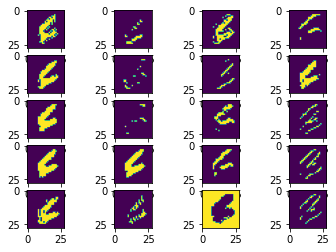

In [57]:
expCorrect = 0

picNumber = len(val_db)
M=1
nodeN=20
picSample,_ = val_db[0]
height = picSample.size()[1]
width = picSample.size()[2]

model.eval()
with torch.no_grad():


    tempimg, templabel= val_db[17]

    label2=torch.tensor(templabel, dtype=float)
    label2 = torch.unsqueeze(label2,dim=0) 

    tempimg2 = torch.unsqueeze(tempimg,dim=0)

    outAfterConv=model.convdense(tempimg2.to(DEVICE)) #xx,16,28,28

    
    tempAfterCustom=torch.zeros(1, nodeN, height, width).to(DEVICE) #用实验的激活函数画特征图
    for jj in range (nodeN):
        fig1 = outAfterConv[:,jj,:,:].expand(1, M, height, width)
        noiseEta = model.customdense.sigma[0,jj,0,0]*torch.randn(1,M, height, width).to(DEVICE)
        thres = model.customdense.theta[0,jj,0,0].to(DEVICE)
        #fig2 = 0.5*(torch.sign(fig1+noiseEta-thres)+1)
        fig2 = 0.5*(torch.sign(fig1-thres)+1)
        fig3 = torch.mean(fig2,dim=1,keepdim=True)
        tempAfterCustom[:,jj,:,:] = fig3.view(1, height, width)

    outAfterCustom = tempAfterCustom
    outAfterPool= torch.max_pool2d(outAfterCustom, 2, 2)
    outBeforeFc1 = outAfterPool.view(1, -1) 
    outAfterFc1 = model.fc1(outBeforeFc1)
    
    outBeforeFc2 = model.customFc1(outAfterFc1)
    outAfterFc2 = model.fc2(outBeforeFc2)

    outExp=F.log_softmax(outAfterFc2, dim=1)

    expPred = outExp.max(1,keepdim=True)[1]
    expCorrectExpri = expPred.eq(label2.view_as(expPred).to(DEVICE)).item()
    

    
print(expCorrectExpri,expPred.cpu().data.numpy())

featurePic_con=outAfterConv.cpu().data.numpy()  #得到经过卷积层后的图

plt.imshow(tempimg.data.reshape(28,28))
for kk in range (20):  #画特征图
    plt.subplot(5,4,kk+1)
    plt.imshow(outAfterCustom[0,kk,:])
    print(outAfterCustom[0,kk,:])


In [139]:
print(tempimg.data.reshape(28,28))
b = tempimg.reshape(-1,1)
print(b)


tensor([[0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
         0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
         0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
         0.0000],
        [0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
         0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
         0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
         0.0000],
        [0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
         0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
         0.0510, 0.7490, 1.0000, 0.3529, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
         0.0000],
        [0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
         0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0745,
         0.7098, 0.9882, 0.9922, 0.8392, 0.1216, 0.0000

In [27]:
print (model.customdense.sigma)
print (model.customFc1.sigma)

Parameter containing:
tensor([[[[0.3884]],

         [[0.1359]],

         [[0.2580]],

         [[0.4994]],

         [[0.3592]],

         [[0.1988]],

         [[0.4826]],

         [[0.4671]],

         [[0.4132]],

         [[0.2879]],

         [[0.4582]],

         [[0.3023]],

         [[0.3519]],

         [[0.3636]],

         [[0.4021]],

         [[0.2224]],

         [[0.3517]],

         [[0.4076]],

         [[0.5184]],

         [[0.3397]]]], requires_grad=True)
Parameter containing:
tensor([[0.3286, 0.4998, 0.3191, 0.2410, 0.3259, 0.4640, 0.4077, 0.2940, 0.4997,
         0.3059, 0.5000, 0.2654, 0.3243, 0.2841, 0.5010, 0.2588, 0.3330, 0.5015,
         0.2342, 0.2971, 0.4064, 0.3165, 0.5002, 0.3129, 0.3809, 0.5001, 0.2607,
         0.3722, 0.2556, 0.5000, 0.3193, 0.2839, 0.4988, 0.5030, 0.3489, 0.5004,
         0.5005, 0.2750, 0.2792, 0.1938, 0.3137, 0.5009, 0.2147, 0.5000, 0.2359,
         0.2353, 0.2262, 0.2569, 0.2813, 0.2899, 0.2532, 0.0920, 0.5000, 0.2112,
         

In [104]:
#print(para3)   #储存卷积层每一步的sigma
frame1=pd.DataFrame(para3.data.numpy()) 
frame1.to_csv('C:/results/conv_sigma.csv',index=False)

#print(para3)   #储存全连接层每一步的sigma
frame1=pd.DataFrame(para4.data.numpy()) 
print(frame1)
frame1.to_csv('C:/results/Fc1_sigma.csv',index=False)

               0
0       0.479258
1       0.500067
2       0.494406
3       0.497811
4       0.486999
...          ...
127995  0.277665
127996  0.242282
127997  0.137059
127998  0.189043
127999  0.500309

[128000 rows x 1 columns]


In [192]:
#注意！上面的程序用验证集充当测试集。如果要用mnist的测试集，用下面的代码，然后把上一个模块中的测试代码test(model, DEVICE, val_loader)变成tr

In [61]:
frame1=pd.DataFrame(para1.data.numpy()) 
frame1.to_csv('C:/results/loss_train2.csv',index=False)
frame1=pd.DataFrame(para2.data.numpy()) 
frame1.to_csv('C:/results/valid_correct2.csv',index=False)


In [14]:
for name, param in model.named_parameters():
    print (name)

convdense.0.weight
convdense.0.bias
convdense.1.weight
convdense.1.bias
customdense.sigma
customdense.theta
fc1.weight
fc1.bias
customFc1.sigma
customFc1.theta
fc2.weight
fc2.bias


In [24]:
frame1=pd.DataFrame(model.fc1.bias.data.numpy())  #存最终的sigma和theta

frame1.to_csv('C:/results/fc1bias.csv',index=False) 
frame2=pd.DataFrame(model.fc1.weight.data.numpy())  #
frame2.to_csv('C:/results/fc1weight.csv',index=False) 
frame3=pd.DataFrame(model.fc2.bias.data.numpy())  #存
frame3.to_csv('C:/results/fc2bias.csv',index=False) 
frame4=pd.DataFrame(model.fc2.weight.data.numpy())  #
frame4.to_csv('C:/results/fc2weight.csv',index=False) 
frame5=pd.DataFrame(model.bn1.bias.data.numpy()) 
frame5.to_csv('C:/results/bn1bias.csv',index=False) 
frame6=pd.DataFrame(model.bn1.weight.data.numpy()) 
frame6.to_csv('C:/results/bn1weight.csv',index=False) 


In [20]:
a = model.conv1.weight.detach().numpy()  #存所有的卷积核
b = a.reshape(-1,9) #把三维的卷积核转化为9*16的矩阵进行存储
np.savetxt('conv1weight.csv',b,delimiter=',')

a = model.conv1.bias.detach().numpy() #存卷积层的偏执
b = a.reshape(-1,1)
np.savetxt('conv1bias.csv',b,delimiter=',')


a = model.custom1.sigma.detach().numpy()  # 存归一化的系数
b = a.reshape(-1,1)
np.savetxt('custom1sigma.csv',b,delimiter=',')

a = model.custom1.theta.detach().numpy()
b = a.reshape(-1,1)
np.savetxt('custom1theta.csv',b,delimiter=',')